# Starbucks Capstone Challenge

## Abstract

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [591]:
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import utils.extract_transform as et
from pandas._testing import assert_frame_equal
%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Cleaning

### Portfolio

In [51]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [52]:
# Available channels
channels = ["email", "mobile", "social", "web"]

# Create a one hot encoding for channel type
portfolioWithChannelsEncoded = portfolio.copy()
for channel in channels:
    portfolioWithChannelsEncoded[channel] = portfolio["channels"].apply(lambda cs: 1*(channel in cs))

portfolio_df = portfolioWithChannelsEncoded.drop(columns="channels")

# Give a descriptive name
portfolio_df["code"] = portfolio_df["offer_type"].str[0] + "." + \
    portfolio_df["difficulty"].astype(str) + "."  + \
    portfolio_df["reward"].astype(str) + "."  + \
    portfolio_df["duration"].astype(str)

# Rename and order columns and rows
portfolio_df = portfolio_df.rename(columns={"id": "offer_id", "offer_type": "type"})
cols = ["offer_id","code","type","difficulty","reward","duration","email","mobile","social","web"]
assert set(cols) == set(portfolio_df.columns)
portfolio_df = portfolio_df[cols]
portfolio_df = portfolio_df.sort_values(["type", "difficulty", "reward", "duration"])

portfolio_df

,offer_id,code,type,difficulty,reward,duration,email,mobile,social,web
8,f19421c1d4aa40978ebb69ca19b0e20d,b.5.5.5,bogo,5,5,5,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,b.5.5.7,bogo,5,5,7,1,1,0,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,b.10.10.5,bogo,10,10,5,1,1,1,1
0,ae264e3637204a6fb9bb56bc8210ddfd,b.10.10.7,bogo,10,10,7,1,1,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,d.7.3.7,discount,7,3,7,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,d.10.2.7,discount,10,2,7,1,1,0,1
6,fafdcd668e3743c1bb461111dcafc2a4,d.10.2.10,discount,10,2,10,1,1,1,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,d.20.5.10,discount,20,5,10,1,0,0,1
7,5a8bc65990b245e5a138643cd4eb9837,i.0.0.3,informational,0,0,3,1,1,1,0
2,3f207df678b143eea3cee63160fa8bed,i.0.0.4,informational,0,0,4,1,1,0,1


In [589]:
# Make sure the functions are up to date
assert_frame_equal(portfolio_df, et.loadAndCleanPortfolio())

### Profile

In [592]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [593]:
profile_df = profile.copy()

# Convert date to an int
profile_df["became_member_on"] = pd.to_datetime(profile["became_member_on"].astype(str)).astype(int)
# Get dummies for gender
profile_df = pd.concat([profile_df, pd.get_dummies(profile_df["gender"])], axis=1)
# Rename and order columns
profile_df = profile_df.rename(columns={"id": "person"})
profile_df = profile_df[["person", "age", "income", "became_member_on", "F", "M"]]

profile_df.head()

,person,age,income,became_member_on,F,M
0,68be06ca386d4c31939f3a4f0e3dd783,118,NaN,1486857600000000000,0,0
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1500076800000000000,1,0
2,38fe809add3b4fcf9315a9694bb96ff5,118,NaN,1531353600000000000,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1494288000000000000,1,0
4,a03223e636434f42ac4c3df47e8bac43,118,NaN,1501804800000000000,0,0


In [607]:
# Make sure the functions are up to date
assert_frame_equal(profile_df, et.loadAndCleanProfile())

### Transcript

In [55]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [56]:
# Check the unique keys present in the value column
transcript['value'].apply(lambda d: d.keys()).explode().unique()

array(['offer id', 'amount', 'offer_id', 'reward'], dtype=object)

In [57]:
transcript_temp = transcript.copy()

# Create event number per person
transcript_temp = transcript_temp.sort_values(["person", "time"])
transcript_temp["event_no"] = transcript_temp.groupby("person").cumcount() + 1

# Explode value column to a list of key-values pairs
transcript_temp["aux"] = transcript_temp["value"].apply(lambda d: d.items())
transcript_temp = transcript_temp.explode("aux")

# Extract key and value for each exploded row
transcript_temp["k"] = transcript_temp["aux"].str[0]
transcript_temp["v"] = transcript_temp["aux"].str[1]

transcript_temp

,person,event,value,time,event_no,aux,k,v
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,1,"(offer id, 5a8bc65990b245e5a138643cd4eb9837)",offer id,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,2,"(offer id, 5a8bc65990b245e5a138643cd4eb9837)",offer id,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,3,"(amount, 22.16)",amount,22.16
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,4,"(offer id, 3f207df678b143eea3cee63160fa8bed)",offer id,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,5,"(offer id, 3f207df678b143eea3cee63160fa8bed)",offer id,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...,...,...,...,...
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,30,"(offer_id, 2906b810c7d4411798c6938adc9daaa5)",offer_id,2906b810c7d4411798c6938adc9daaa5
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,30,"(reward, 2)",reward,2
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582,31,"(offer id, 2906b810c7d4411798c6938adc9daaa5)",offer id,2906b810c7d4411798c6938adc9daaa5
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606,32,"(amount, 10.12)",amount,10.12


In [58]:
# Pivot
transcript_df = transcript_temp.pivot(
        index=["person", "event_no", "event", "time"],
        columns="k",
        values="v"
    )

# Reset index
transcript_df = transcript_df.reset_index()
transcript_df.columns.name = None

# Clean up values
transcript_df["offer_id"] = transcript_df["offer_id"].combine_first(transcript_df["offer id"])
transcript_df = transcript_df.drop(columns="offer id")
transcript_df["amount"] = pd.to_numeric(transcript_df["amount"])

# Fill amount and reward with 0 when nan for ease of manipulation
transcript_df["amount"] = transcript_df["amount"].fillna(0)
transcript_df["reward"] = transcript_df["reward"].fillna(0)

transcript_df

,person,event_no,event,time,amount,offer_id,reward
0,0009655768c64bdeb2e877511632db8f,1,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0
1,0009655768c64bdeb2e877511632db8f,2,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0
2,0009655768c64bdeb2e877511632db8f,3,transaction,228,22.16,NaN,0
3,0009655768c64bdeb2e877511632db8f,4,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,0
4,0009655768c64bdeb2e877511632db8f,5,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,0
...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,29,transaction,576,14.23,NaN,0
306530,ffff82501cea40309d5fdd7edcca4a07,30,offer completed,576,0.00,2906b810c7d4411798c6938adc9daaa5,2
306531,ffff82501cea40309d5fdd7edcca4a07,31,offer viewed,582,0.00,2906b810c7d4411798c6938adc9daaa5,0
306532,ffff82501cea40309d5fdd7edcca4a07,32,transaction,606,10.12,NaN,0


In [595]:
# Make sure the functions are up to date
assert_frame_equal(transcript_df, et.loadAndCleanTranscript())

## Initial Exploratory Data Analysis

count    243354.000000
mean        110.102221
std          96.019607
min           0.000000
25%          36.000000
50%          78.000000
75%         168.000000
max         708.000000
Name: time_since_last, dtype: float64


<AxesSubplot:>

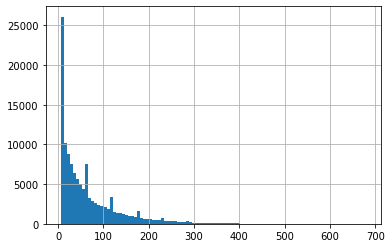

In [59]:
transcript_eda = transcript_df.copy()

# Histogram of time between purchases
transcript_eda["last_time"] = transcript_eda.groupby(["person","event"])["time"].shift(1)
transcript_eda["time_since_last"] = transcript_eda["time"] - transcript_eda["last_time"]
print(transcript_eda["time_since_last"].describe())
transcript_eda.loc[transcript_eda["event"]=="transaction", "time_since_last"].hist(bins=100)

In [60]:
transcript_eda.loc[transcript_eda["event"]=="transaction"].sample(10)

,person,event_no,event,time,amount,offer_id,reward,last_time,time_since_last
181774,97b6a247534840ec9e7bba870f512d2e,6,transaction,420,3.72,NaN,0,54.0,366.0
47984,29886d76e4264150923c4be1bbe4559a,11,transaction,378,0.57,NaN,0,324.0,54.0
203660,a93b655903f249c7bc074c0b4b69f52e,10,transaction,588,0.98,NaN,0,6.0,582.0
248927,cfc4bbee38734ac2a99ecc012ae12f0d,20,transaction,606,0.62,NaN,0,570.0,36.0
190256,9e2ba3d151564f86900754e6036febba,3,transaction,66,1.88,NaN,0,18.0,48.0
94811,4ebf3a190a1848119826a7e2ed3cbcc1,6,transaction,450,1.57,NaN,0,402.0,48.0
197294,a3e400d45651427c822dae47cd410770,7,transaction,252,0.42,NaN,0,138.0,114.0
179146,95765fd88ae6450e804c6faeb77b45be,11,transaction,264,2.57,NaN,0,246.0,18.0
212901,b0ca734e01744520aea416f1c9f98f9d,15,transaction,492,14.97,NaN,0,402.0,90.0
227010,bc8f94f7e220405393414f17b3fe25c5,10,transaction,312,33.65,NaN,0,144.0,168.0


In [61]:
portfolio_df

,offer_id,code,type,difficulty,reward,duration,email,mobile,social,web
8,f19421c1d4aa40978ebb69ca19b0e20d,b.5.5.5,bogo,5,5,5,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,b.5.5.7,bogo,5,5,7,1,1,0,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,b.10.10.5,bogo,10,10,5,1,1,1,1
0,ae264e3637204a6fb9bb56bc8210ddfd,b.10.10.7,bogo,10,10,7,1,1,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,d.7.3.7,discount,7,3,7,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,d.10.2.7,discount,10,2,7,1,1,0,1
6,fafdcd668e3743c1bb461111dcafc2a4,d.10.2.10,discount,10,2,10,1,1,1,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,d.20.5.10,discount,20,5,10,1,0,0,1
7,5a8bc65990b245e5a138643cd4eb9837,i.0.0.3,informational,0,0,3,1,1,1,0
2,3f207df678b143eea3cee63160fa8bed,i.0.0.4,informational,0,0,4,1,1,0,1


In [610]:
# Effectiveness of each channel in converting with promotion
promo_funnel = transcript_eda.groupby(["offer_id", "event"]).size().unstack()
promo_funnel = promo_funnel.fillna(0).astype(int)
promo_funnel["view_rate"] = promo_funnel["offer viewed"] / promo_funnel["offer received"]
promo_funnel["comp_rate"] = promo_funnel["offer completed"] / promo_funnel["offer viewed"]
promo_funnel = promo_funnel.reset_index()

promo_funnel = portfolio_df.merge(promo_funnel, on="offer_id").sort_values(
    ["type", "difficulty", "reward", "duration"],
    ascending=[True, True, False, False]
)
promo_funnel

,offer_id,code,type,difficulty,reward,duration,email,mobile,social,web,offer completed,offer received,offer viewed,view_rate,comp_rate
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,b.5.5.7,bogo,5,5,7,1,1,0,1,4354,7677,4171,0.543311,1.043874
0,f19421c1d4aa40978ebb69ca19b0e20d,b.5.5.5,bogo,5,5,5,1,1,1,1,4296,7571,7264,0.959451,0.591410
3,ae264e3637204a6fb9bb56bc8210ddfd,b.10.10.7,bogo,10,10,7,1,1,1,0,3688,7658,6716,0.876991,0.549136
2,4d5c57ea9a6940dd891ad53e9dbe8da0,b.10.10.5,bogo,10,10,5,1,1,1,1,3331,7593,7298,0.961148,0.456426
4,2298d6c36e964ae4a3e7e9706d1fb8c2,d.7.3.7,discount,7,3,7,1,1,1,1,5156,7646,7337,0.959587,0.702740
6,fafdcd668e3743c1bb461111dcafc2a4,d.10.2.10,discount,10,2,10,1,1,1,1,5317,7597,7327,0.964460,0.725672
5,2906b810c7d4411798c6938adc9daaa5,d.10.2.7,discount,10,2,7,1,1,0,1,4017,7632,4118,0.539570,0.975474
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,d.20.5.10,discount,20,5,10,1,0,0,1,3420,7668,2663,0.347287,1.284266
9,3f207df678b143eea3cee63160fa8bed,i.0.0.4,informational,0,0,4,1,1,0,1,0,7617,4144,0.544046,0.000000
8,5a8bc65990b245e5a138643cd4eb9837,i.0.0.3,informational,0,0,3,1,1,1,0,0,7618,6687,0.877789,0.000000


In [611]:
# Make sure the functions are up to date
assert_frame_equal(promo_funnel, et.getPromoFunnel(transcript_df, portfolio_df))

Check if offers are evenly given

<AxesSubplot:ylabel='code'>

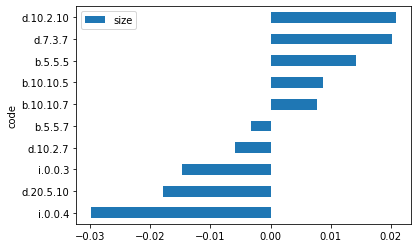

In [63]:
received_offers = transcript_eda[transcript_eda["event"]=="offer received"]
offers_dist = transcript_eda.groupby("offer_id", as_index=False).size()
offers_dist["size"] /= offers_dist["size"].sum()
offers_dist["size"] -= 1/offers_dist.shape[0]
offers_dist = offers_dist.merge(portfolio_df, on="offer_id")
offers_dist = offers_dist.sort_values("size")

offers_dist.plot.barh(x="code", y="size")

In [612]:
# Make sure the functions are up to date
assert_frame_equal(offers_dist, et.getOffersDist(transcript_df, portfolio_df))

## Feature Engineering

In [94]:
transcript_feats = transcript_df.copy()

# Create dummy variables for the events (to perform a cumulative sum)
transcript_feats = pd.concat([transcript_feats, pd.get_dummies(transcript_feats["event"])], axis=1)
transcript_feats["event_no_aux"] = 1

# Define the columns to aggregate, their function and their new name
agg_cols = {
    # original column name: (agg function, agg column name)
    "event_no_aux": ("sum", "event_no"),
    "amount": ("sum", "cum_spending"),
    "reward": ("sum", "cum_reward"),
    "transaction": ("sum", "transactions"),
    "offer received": ("sum", "offers_received"),
    "offer viewed": ("sum", "offers_viewed"),
    "offer completed": ("sum", "offers_completed"),
    "time": ("min", "min_time")
}
aggs = {k: v[0] for k, v in agg_cols.items()}
rename = {k:v[1] for k,v in agg_cols.items()}

# Perform the aggregations on the expanding window partitioned by each person
transcript_aggs = transcript_feats.groupby("person").expanding().agg(aggs)
transcript_aggs = transcript_aggs.rename(columns=rename)
transcript_aggs = transcript_aggs.reset_index().drop(columns="level_1")
transcript_feats = transcript_feats.drop(columns="event_no_aux")
transcript_feats = transcript_feats.merge(transcript_aggs, on=["person", "event_no"])

# Subtract the current "event" so that they account only for the past (without information not available on inference time)
cols_subtract = [col for col in agg_cols.keys() if col not in ["event_no_aux", "time"]]
cols_keep = [rename[col] for col in cols_subtract]
transcript_feats.loc[:, cols_keep] -= transcript_feats.loc[:, cols_subtract].values

# Time since each person's first event
transcript_feats["time_since_first_event"] = transcript_feats["time"] - transcript_feats["min_time"]
transcript_feats = transcript_feats.drop(columns="min_time")

# Average transaction value (up to that point)
transcript_feats["atv"] = transcript_feats["cum_spending"] / transcript_feats["transactions"]
# Percentage of offers completed (completed / received) - up to that point
transcript_feats["offer_usage"] = transcript_feats["offers_completed"] / transcript_feats["offers_received"]

# Time since last transaction, offer received, offer viewed, and offer completed
events = ["offer received", "offer viewed", "transaction", "offer completed"]
transcript_feats = transcript_feats.drop(columns=events)
for event in events:
    # Define auxiliary variables
    event_count = rename[event]
    event_name = event.replace(' ','_')
    cols_aux = ["person", event_count, "time"]
    col_last_event_at = f"last_{event_name}_at"
    # Create filtered dataframe with the times of previous events
    event_times = transcript_feats.loc[transcript_feats["event"]==event, cols_aux]
    event_times[event_count] += 1
    # Join the two dataframes and calculate the time since the last event
    event_times = event_times.rename(columns={"time": col_last_event_at})
    transcript_feats = transcript_feats.merge(event_times, on=["person", event_count], how="left")
    transcript_feats[f"time_since_last_{event_name}"] = transcript_feats["time"] - transcript_feats[col_last_event_at]
    transcript_feats = transcript_feats.drop(columns=col_last_event_at)

# Add offer data
portfolio_renamed = portfolio_df.copy()
portfolio_renamed.columns = [f"offer_{col}" if col!="offer_id" else col for col in portfolio_renamed]
transcript_feats = transcript_feats.merge(portfolio_renamed, on="offer_id", how="left")
# Change offer duration to hours and create time until offers are valid
transcript_feats["offer_duration"] = 24*transcript_feats["offer_duration"]

# Add customer offer timeline
# 1. Select only relevant rows and columns
received_offers = transcript_feats[transcript_feats["event"]=="offer received"]
received_offers = received_offers[["person","event_no","time","event","offer_code","offer_duration"]]
offer_dummies = pd.get_dummies(received_offers["offer_code"], prefix="active")
received_offers = pd.concat([received_offers, offer_dummies], axis=1)
# 2. Repeat rows of offers by their time duration in hours
rep_index = received_offers.index.repeat(received_offers["offer_duration"])
active_offers = received_offers.drop(columns=["event","offer_code","offer_duration"]).loc[rep_index]
active_offers["time"] += active_offers.groupby(["person","event_no"]).cumcount()
# 3. Aggregate the offers by person and time, taking all the valid offers at that time and join
active_offers = active_offers.drop(columns="event_no").groupby(["person","time"], as_index=False).max()
transcript_feats = transcript_feats.merge(active_offers, on=["person","time"], how="left")
# 4. Fill NA and convert value of active offer columns (if it's na, customer didn\t receive it)
offer_cols = [f"active_{offer}" for offer in portfolio_df["code"]]
transcript_feats[offer_cols] = transcript_feats[offer_cols].fillna(0).astype(int)

# Transform remaining offer data
offer_type_dummies = pd.get_dummies(transcript_feats["offer_type"], prefix="offer_type")
transcript_feats = pd.concat([transcript_feats.drop(columns="offer_type"), offer_type_dummies], axis=1)

# Add demografic data
transcript_feats = transcript_feats.merge(profile_df, on="person", how="left")

transcript_feats.head()

,person,event_no,event,time,amount,offer_id,reward,cum_spending,cum_reward,transactions,...,active_i.0.0.3,active_i.0.0.4,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,became_member_on,F,M
0,0009655768c64bdeb2e877511632db8f,1,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0,0.00,0.0,0.0,...,1,0,0,0,1,33,72000.0,1492732800000000000,0,1
1,0009655768c64bdeb2e877511632db8f,2,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0,0.00,0.0,0.0,...,1,0,0,0,1,33,72000.0,1492732800000000000,0,1
2,0009655768c64bdeb2e877511632db8f,3,transaction,228,22.16,NaN,0,0.00,0.0,0.0,...,1,0,0,0,0,33,72000.0,1492732800000000000,0,1
3,0009655768c64bdeb2e877511632db8f,4,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,0,22.16,0.0,1.0,...,0,1,0,0,1,33,72000.0,1492732800000000000,0,1
4,0009655768c64bdeb2e877511632db8f,5,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,0,22.16,0.0,1.0,...,0,1,0,0,1,33,72000.0,1492732800000000000,0,1


In [614]:
assert_frame_equal(
    transcript_feats,
    et.createTranscriptFeatures(transcript_df, portfolio_df, profile_df)
)

## Create Target
We will define the response to the offer as being the **spending each customer makes during its validity period starting in the moment the offer is received**.

In [617]:
# Auxiliary variables
dummy_base_ts = pd.Timestamp("2021-01-01")
last_event_ts = dummy_base_ts + pd.to_timedelta(transcript_feats["time"].max(), "h")
time_windows = sorted(24*portfolio_df["duration"].unique())

# Filter only relevant columns and rows
target_df = transcript_feats[["person","time","event","amount"]].copy()
target_df = target_df[target_df["event"].isin(["offer received", "transaction"])]
Y_df = target_df.copy()

# Add dummy events in the future (to make sure it exists an event at time t+time_window
# for every event occurring at time t) - this is done because rolling is only performed
# for previous rows
dummy_events = target_df.copy().rename(columns={"time": "orig_time"})
dummy_events["amount"] = 0
for time_window in time_windows:
    dummy_events["time"] = dummy_events["orig_time"] + time_window
    target_df = pd.concat([target_df, dummy_events.drop(columns="orig_time")])

# Group concurrent events
# A dummy base timestamp is used because it's needed in the following rolling function
target_df["ts"] = dummy_base_ts + pd.to_timedelta(target_df["time"], "h")
target_df = target_df.drop(columns="time")
target_df = target_df.groupby(["person","ts"], as_index=False).sum()

# Calculate the future spending for each time window (offer durations)
for time_window in time_windows:
    # Rolling sums (closed on the left endpoint so that transactions occurring at the same time, i.e. hour,
    # are included in the future spending)
    rs = target_df.groupby("person", as_index=False).rolling(f"{time_window}h", on="ts", closed="left").sum()
    rs_spending_col_name = f"spending_next_{time_window}h"
    rs = rs.rename(columns={"amount": rs_spending_col_name})

    # Set spendings to NA if time window contains events after the last time in the dataset
    rs[rs_spending_col_name] = rs[rs_spending_col_name].where(rs["ts"] < last_event_ts)

    # Shifts events by the time_window so that the rolling sum is over the future
    rs["time"] = (rs["ts"]-dummy_base_ts).dt.total_seconds()/3600 - time_window
    rs["time"] = rs["time"].astype(int)
    rs = rs.drop(columns="ts")

    Y_df = Y_df.merge(rs, on=["person","time"], how="left")

# Change spending targets to be defined in exclusive time windows
# that way inference with the fitted models are guaranteed to be monotonically non-decreasing
for i in range(len(time_windows)-1, 0, -1):
    spending_col = f"spending_next_{time_windows[i]}h"
    prev_spending_col = f"spending_next_{time_windows[i-1]}h"
    Y_df[spending_col] -= Y_df[prev_spending_col]

Y_df = Y_df[Y_df["event"]=="offer received"]
Y_df = Y_df.drop(columns=["event","amount"])

In [619]:
assert_frame_equal(Y_df, et.createTargets(transcript_feats, portfolio_df))

In [621]:
# Create training dataset
df_full = transcript_feats[transcript_feats["event"]=="offer received"].copy()
df_full = df_full.merge(Y_df, on=["person","time"], how="left").reset_index(drop=True)
df = df_full.drop(columns=[
        "person","event_no","time","event","amount","reward","offer_id","offer_code"]
    ).copy()

df.head()

,cum_spending,cum_reward,transactions,offers_received,offers_viewed,offers_completed,time_since_first_event,atv,offer_usage,time_since_last_offer_received,...,age,income,became_member_on,F,M,spending_next_72h,spending_next_96h,spending_next_120h,spending_next_168h,spending_next_240h
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,33,72000.0,1492732800000000000,0,1,22.16,0.00,0.00,0.00,0.00
1,22.16,0.0,1.0,1.0,1.0,0.0,168.0,22.160,0.000000,168.0,...,33,72000.0,1492732800000000000,0,1,0.00,8.57,0.00,0.00,27.67
2,22.16,0.0,1.0,2.0,2.0,0.0,240.0,22.160,0.000000,72.0,...,33,72000.0,1492732800000000000,0,1,8.57,0.00,0.00,27.67,10.27
3,30.73,5.0,2.0,3.0,3.0,1.0,336.0,15.365,0.333333,96.0,...,33,72000.0,1492732800000000000,0,1,27.67,10.27,0.00,12.36,NaN
4,58.40,7.0,4.0,4.0,4.0,2.0,408.0,14.600,0.500000,72.0,...,33,72000.0,1492732800000000000,0,1,10.27,12.36,28.16,NaN,NaN


In [622]:
assert_frame_equal(df, et.getTrainingDataset(transcript_feats, Y_df))

## Assessing offer responsiveness

Next, we will determine which demographic groups respond best to which offer type using two different appraches:
1. **Descriptive approach**: we segment customers based on their demographic groups and assess how much they spent for every type of offer
2. **Predictive approach**: we utilize various features to try to predict how much each customer will spend by varying which offer they receive and then selecting the one that maximizes the profit

## 1. Descriptive Approach

### Defining Demographic Groups

Since the demographic groups are probabily going to be used to define marketing campaigns, they should be easily interpretable and with common traits. Thus, we will adopt a manual approach for defining them. We start by defining age groups, then income groups, followed by subscription time and finnally by gender.

In [443]:
demographics = profile.copy()
demographics["became_member_on"] = pd.to_datetime(demographics["became_member_on"].astype(str)).astype(int)

demographics.head()

/Users/Felipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,1486857600000000000,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,1500076800000000000,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,1531353600000000000,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1494288000000000000,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,1501804800000000000,NaN


In [442]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


#### Age Groups

<AxesSubplot:>

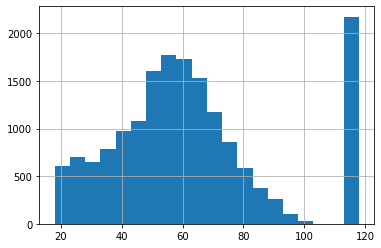

In [465]:
demographics["age"].hist(bins=20)

Some conclusions can be drawn from the histogram above:
* There are some outliers with age above 100 (these are probably customers who have filled the field incorrectly)
* The majority of customers have between 50 and 70 years old
* Customers with age bellow 50 are roughly uniformly distributed wheareas those above 70 rapidly decrease with the age

With that in mind, meaningful age groups can be defined as follows:
1. Under 30 (this group is set apart since they usually display a different behaviour than the next one)
2. Between 30 and 50
3. Between 50 and 70
4. Between 70 and 100
5. Above 100 (since this groups is large and probabily don't have this age, it will also be set apart)

In [467]:
demographics["age_group"] = pd.cut(demographics["age"], [0, 30, 50, 70, 100, 200], labels=np.arange(5)+1)
demographics.head()

,gender,age,id,became_member_on,income,age_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,1486857600000000000,NaN,5
1,F,55,0610b486422d4921ae7d2bf64640c50b,1500076800000000000,112000.0,3
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,1531353600000000000,NaN,5
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1494288000000000000,100000.0,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,1501804800000000000,NaN,5


#### Income Groups

<AxesSubplot:>

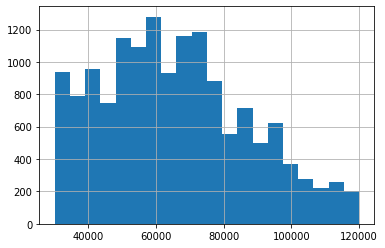

In [468]:
demographics["income"].hist(bins=20)

Here we don't see any much patterns as we did with age groups. Thus, we'll create 4 income groups defined by the percentiles as follows:
1. 20% and bellow
2. Between the 20% and 80% percentile
3. Above the 80% percentile
4. Missing income data

In [484]:
demographics["income_group"] = pd.qcut(demographics["income"], [0, .2, .8, 1], labels=[0, 1, 2])
demographics.head()

,gender,age,id,became_member_on,income,age_group,income_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,1486857600000000000,NaN,5,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,1500076800000000000,112000.0,3,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,1531353600000000000,NaN,5,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1494288000000000000,100000.0,4,2
4,None,118,a03223e636434f42ac4c3df47e8bac43,1501804800000000000,NaN,5,NaN


#### Cohort Groups

<AxesSubplot:>

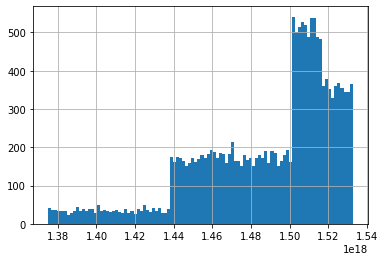

In [485]:
demographics["became_member_on"].hist(bins=100)

Here it's easy to see distinctive groups. Let's find the threshold for each of them.

<AxesSubplot:>

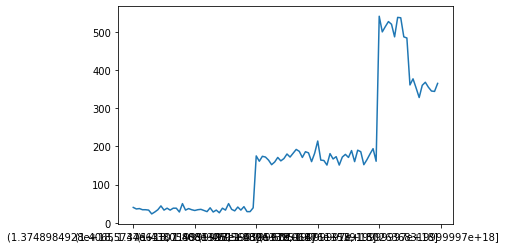

In [486]:
demographics["became_member_on"].value_counts(bins=100, sort=False).plot()

In [487]:
bins = demographics["became_member_on"].value_counts(bins=100, sort=False).to_frame()
bins.columns = ["count"]
bins["dcount"] = bins["count"].shift(1) - bins["count"]
breaks = bins[abs(bins["dcount"])>100]
breaks

,count,dcount
"(1.43805888e+18, 1.4396339519999997e+18]",175,-136.0
"(1.50106176e+18, 1.5026368319999997e+18]",541,-380.0
"(1.51681248e+18, 1.5183875520000003e+18]",361,123.0


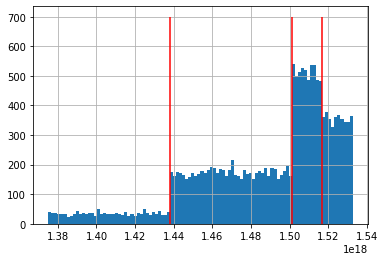

In [488]:
subs_time_th = breaks.index.left

demographics["became_member_on"].hist(bins=100)
plt.vlines(subs_time_th, 0, 700, colors='r')

In [496]:
cohort_breaks = [0] + list(breaks.index.left) + list([demographics["became_member_on"].max()])
demographics["cohort_group"] = pd.cut(demographics["became_member_on"], cohort_breaks, labels=[1,2,3,4])

demographics.head()

,gender,age,id,became_member_on,income,age_group,income_group,cohort_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,1486857600000000000,NaN,5,NaN,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,1500076800000000000,112000.0,3,2,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,1531353600000000000,NaN,5,NaN,4
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1494288000000000000,100000.0,4,2,2
4,None,118,a03223e636434f42ac4c3df47e8bac43,1501804800000000000,NaN,5,NaN,3


#### Gender Groups

No work need to be done here as the genders are already in meaningful groups.

In [497]:
demographics.head()

,gender,age,id,became_member_on,income,age_group,income_group,cohort_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,1486857600000000000,NaN,5,NaN,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,1500076800000000000,112000.0,3,2,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,1531353600000000000,NaN,5,NaN,4
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1494288000000000000,100000.0,4,2,2
4,None,118,a03223e636434f42ac4c3df47e8bac43,1501804800000000000,NaN,5,NaN,3


In [623]:
# Make sure the functions are up to date
assert_frame_equal(demographics, et.createDemographicGroups(profile))

### Demographic groups more susceptible to the offer

In [566]:
# Merge the demographic data
demog_cols = ["age_group", "income_group", "cohort_group", "gender"]
demographics_groups = demographics[["id"] + demog_cols]
demographics_groups = demographics_groups.rename(columns={"id": "person"})
susceptibility = df_full.merge(demographics_groups, on="person", how="left")

# Coalesce spending windows into a spending for the specific duration of the offer received
target_col = "spending_offer_duration"
for t in time_windows:
    spend_col = f"spending_next_{t}h"
    window_mask = susceptibility["offer_duration"]==t
    susceptibility.loc[window_mask, target_col] = susceptibility.loc[window_mask, spend_col]

# Subset columns
feat_cols = demog_cols + ["offer_code"]
susceptibility = susceptibility[feat_cols + [target_col]]

# Drop rows where the end of the offer exceeded the last observed time
susceptibility = susceptibility.dropna(subset=[target_col])

# Get aggregate spendings by demographic groups and offers (median to filter outliers)
agg_metrics = {target_col: ["median","size"]}
metric_names = ["spending_median", "size"]
spendings_per_groups = susceptibility.groupby(feat_cols).agg(agg_metrics).reset_index()
spendings_per_groups.columns = feat_cols + metric_names

# Drop groups with small sample size
spendings_per_groups = spendings_per_groups[spendings_per_groups["size"] >= 30]

spendings_per_groups.head()

,age_group,income_group,cohort_group,gender,offer_code,spending_median,size
10,1,0,1,M,b.10.10.5,10.130,30
12,1,0,1,M,b.5.5.5,11.015,36
18,1,0,1,M,i.0.0.3,4.710,30
19,1,0,1,M,i.0.0.4,3.565,34
30,1,0,2,F,b.10.10.5,30.930,35


In [567]:
offer_sample = spendings_per_groups[spendings_per_groups["offer_code"]=="b.10.10.5"]
offer_sample = offer_sample.sort_values("spending_median", ascending=False)
offer_sample

,age_group,income_group,cohort_group,gender,offer_code,spending_median,size
1360,4,2,2,M,b.10.10.5,4.967000e+01,74
630,2,2,2,F,b.10.10.5,4.808000e+01,47
640,2,2,2,M,b.10.10.5,4.693500e+01,34
1350,4,2,2,F,b.10.10.5,4.293000e+01,87
1000,3,2,2,M,b.10.10.5,4.098000e+01,139
...,...,...,...,...,...,...,...
580,2,1,4,M,b.10.10.5,2.060000e+00,149
1290,4,1,4,F,b.10.10.5,9.000000e-01,70
1060,3,2,4,M,b.10.10.5,1.136868e-13,51
1050,3,2,4,F,b.10.10.5,2.131628e-14,82


### Spendings based on each demographic feature

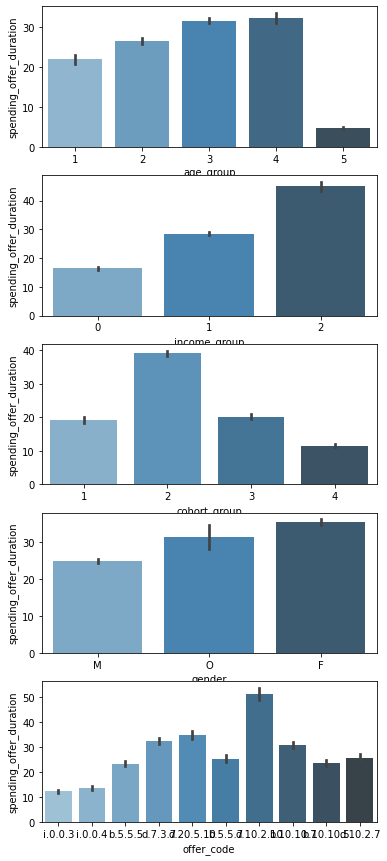

In [571]:
_, axs = plt.subplots(len(feat_cols), 1, figsize=(6, 15))

for i, col in enumerate(feat_cols):
    sns.barplot(x=col, y=target_col, data=susceptibility, palette="Blues_d", ax=axs[i])

## 2. Predictive Approach

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Percentage of test splits for events in the future and holdout customers
test_split = 0.2
split_test_customers = .1
split_test_future = (test_split - split_test_customers)/(1-split_test_customers)

# Create regression model to predict spending
# 1. Drop correlated features / Make feature eng (mainly interactions)
  # analyze correlation matrix
  # specially marketing channels

# 2. Split train and tests datasets (sample customers and customer events occurring after xx% of their timeline length)
df_split_data = df_full[["person","offers_received"]].copy()
# Offers received corresponds to the row number of the customer
df_split_data["offers_received"] = df_split_data["offers_received"].astype(int) + 1
df_split_data["total_offers_received"] = df_split_data.groupby("person")["offers_received"].transform("max")
# Calculate for all customer the number of rows of "past" events to keep in the training set
df_split_data["training_rows"] = (1-split_test_future)*df_split_data["total_offers_received"]
df_split_data["training_rows"] = (df_split_data["training_rows"].round(0)).astype(int)
# Sample random holdout customers to test set and merge
holdout_test_customers = df_split_data[["person"]].drop_duplicates().sample(frac=split_test_customers)
holdout_test_customers["holdout_customer"] = True
df_split_data = df_split_data.merge(holdout_test_customers, on="person", how="left")
df_split_data["holdout_customer"] = df_split_data["holdout_customer"].fillna(False)
# Create flag for test set
mask_test_future = df_split_data["offers_received"] > df_split_data["training_rows"]
df_split_data["test_set"] = df_split_data["holdout_customer"] | mask_test_future
assert round(df_split_data["test_set"].value_counts(normalize=True)[True], 1) == test_split, \
       f"Overall test split is not {test_split:.0%}"
assert all(df.index == df_split_data.index), "Indices of split dataframe don't match original"
# Split datasets
train_df = df[~df_split_data["test_set"]]
test_df = df[df_split_data["test_set"]]
# Split features and target
target_cols = [f"spending_next_{time_window}h" for time_window in time_windows]
X_train, X_test = train_df.drop(columns=target_cols), test_df.drop(columns=target_cols)
Y_train, Y_test = train_df[target_cols], test_df[target_cols]
assert df.shape[1] == pd.concat([X_train, Y_train], axis=1).shape[1], "Split is dropping or duplicating columns"
assert df.shape[1] == pd.concat([X_test, Y_test], axis=1).shape[1], "Split is dropping or duplicating columns"
assert df.shape[0] == pd.concat([X_train, X_test]).shape[0], "Split is dropping or duplicating rows"
assert df.shape[0] == pd.concat([Y_train, Y_test]).shape[0], "Split is dropping or duplicating rows"

# 3. Train and test models
# clf = MultiOutputRegressor(xgb.XGBRegressor()).fit(X_train, Y_train) -> cannot be used because of missing targets
# A parameter grid for XGBoost
params = {
  'min_child_weight': [1, 5, 10],
  'gamma': [0.5, 1, 1.5, 2, 5],
  'subsample': [0.6, 0.8, 1.0],
  'colsample_bytree': [0.6, 0.8, 1.0],
  'max_depth': [3, 4, 5]
}
models = []
for target_col in target_cols:
  # Drop na rows
  y_train, y_test = Y_train[target_col], Y_test[target_col]
  na_target_mask_train = y_train.isna()
  na_target_mask_test = y_test.isna()
  x_train, x_test = X_train[~na_target_mask_train], X_test[~na_target_mask_test]
  y_train, y_test = y_train[~na_target_mask_train], y_test[~na_target_mask_test]

  # Train and append to the list of fitted models
  skf = StratifiedKFold(n_splits=3)
  random_search = RandomizedSearchCV(
    xgb.XGBRegressor(),
    param_distributions=params,
    n_iter=10,
    scoring='r2',
    n_jobs=4,
    #cv=skf.split(x_train, y_train),
    verbose=3
  ).fit(x_train, y_train)
  clf = random_search.best_estimator_

  # Assess errors on training set
  y_pred = clf.predict(x_train)
  rmse_train = mean_squared_error(y_train, y_pred, squared=False)
  r2_train = r2_score(y_train, y_pred)

  # Assess errors on test set
  y_pred = clf.predict(x_test)
  rmse_test = mean_squared_error(y_test, y_pred, squared=False)
  r2_test = r2_score(y_test, y_pred)

  models.append({
    "target": target_col,
    "classifier": clf,
    "rmse_train": rmse_train,
    "r2_train": r2_train,
    "rmse_test": rmse_test,
    "r2_test": r2_test
  })

  # TODO: change the assessment on the different groups (holdout and future)
  # and change the comparison to be that between the sum of prediction for
  # previous time windows

# 4. Assess errors in the three regions defined by step 2

# 5. Assess coefficients for the boolean features for valid offers

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=1, subsample=0.6;, score=-0.063 total time=  25.5s
[CV 3/5] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=1, subsample=0.6;, score=-0.063 total time=  25.6s
[CV 4/5] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=1, subsample=0.6;, score=-0.040 total time=  25.6s
[CV 1/5] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=1, subsample=0.6;, score=-0.033 total time=  25.6s
[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.042 total time=  21.7s
[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.057 total time=  21.9s
[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.052 total time=  22.1s
[CV 5/5] END colsample_bytree=1.0, gamma=2, max_depth=5, min_chi

In [ ]:
models[4]

{'target': 'spending_next_240h',
 'classifier': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'rmse_train': 55.04397873834697,
 'r2_train': 0.25712497647251054,
 'rmse_test': 67.05796003647617,
 'r2_test': 0.15611428274447903}

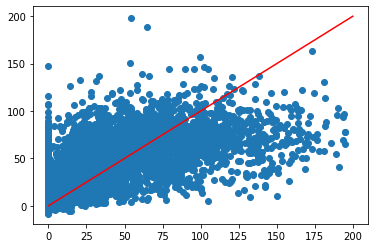

In [ ]:
import matplotlib.pyplot as plt

mask_outliers = y_test < 200
plt.scatter(x=y_test[mask_outliers], y=y_pred[mask_outliers])
plt.plot([0,200], [0,200], c='r')

In [ ]:
for model in models:
    print("Target:", model["target"])
    print("RMSE train:", model["rmse_train"])
    print("RMSE test:", model["rmse_test"])
    print("R2 train:", model["r2_train"])
    print("R2 test:", model["r2_test"])
    print()

Target: spending_next_72h
RMSE train: 21.495703773553394
RMSE test: 39.20560578384945
R2 train: 0.5805752892668625
R2 test: -0.20401476931101215

Target: spending_next_96h
RMSE train: 25.650975755775853
RMSE test: 44.50366727349514
R2 train: 0.5754761805233021
R2 test: -0.14653464012207218

Target: spending_next_120h
RMSE train: 28.845917783442033
RMSE test: 48.362589192739975
R2 train: 0.595723082604062
R2 test: -0.11193297222374032

Target: spending_next_168h
RMSE train: 35.37349980442904
RMSE test: 48.85013128217347
R2 train: 0.5681181243634972
R2 test: 0.053002191707976376

Target: spending_next_240h
RMSE train: 40.68588969164982
RMSE test: 63.163432848364465
R2 train: 0.6028178582336401
R2 test: 0.12180296058959672



In [ ]:
# Number of features in last 7/14/21 days (number of transactions in the last x days)
# replace by mean and mode times of purchases
# Actually, make the "momentum": sum of the inverse of time differences: sum(1/(today - time_purchase[k]))
# or use the exponential smoothing

# Z-Score of time between purchases (time since last transaction - avg) / std
#transcript_feats["avg_time_between_purchases"] = transcript_feats["sum_time_since_last_purchase"] / transcript_feats["transactions"]
#transcript_feats.loc[transcript_feats["event"]!="transaction", "avg_time_between_purchases"] = np.nan
